In [ ]:
%%capture
!rm -rf ObjectEllicitationNLP
!git clone https://github.com/yurisugano/ObjectEllicitationNLP.git
!pip install python-docx
!pip install -q -U spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.6.0/en_core_web_md-3.6.0.tar.gz
!pip install sentence_transformers
!pip install babyplots

!pip install openai
!pip install bertopic

# Hyperparameter tuning

Algorithms  take **hyperparameters**: user-specified values that determine the behavior and the output of an algorithm.

We'll visualize the effects of different hyperparameters on the behavior of the algorithms behind the creation, distribution, composition and labeling of topics.


## Dimensionality reduction

We'll use `UMAP` to reduce dimensions. One advantage of UMAP is that its hyperparameters allow it to behave like other popular dimensionality reduction algorithms such as `PCA` or `t-SNE`. For information on UMAP and how it compares to other algorithms, see [here](https://arxiv.org/abs/1802.03426)

To visualize UMAP's hyperparameters, consider a 3D cube. We will try to reduce the cube to 2D while preserving as much information as possible. This also demonstrates how dimensionality reduction affects topic creation


1. Do we want to preserve local structure? That is, neighbors in higher dimension should remain close in lower dimension, preserving neighborhood topics
2. Do we want to preserve global structure? That is, the large organization of the cube should be visible in lower dimension, only preserving large topics?

To help visualizing the 3D features, we create a cube that has a (r,g,b) colors based on its (x,y,z) coordinates. As such, when mapping to 2D we can still see its 3D features through color.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Create an RGB cube
r, g, b = np.indices((256, 256, 256))
rgb_cube = np.vstack([r.flatten(), g.flatten(), b.flatten()]).T

# Normalize the RGB values to [0, 1]
rgb_cube = rgb_cube / 255.0

# Select a random sample of points
indices = np.random.choice(rgb_cube.shape[0], size=300, replace=False)
rgb_sample = rgb_cube[indices]


import plotly.graph_objects as go

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=rgb_sample[:, 0],
    y=rgb_sample[:, 1],
    z=rgb_sample[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=['rgb'+str(tuple(val)) for val in (rgb_sample*255).astype(int)],  # set color to RGB values
        opacity=0.8
    )
)])

# Tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))

fig.show()

(the graph above is interactive. Click-and-drag to move around. Focus on a section to see how the features are represented in 2D)

We will see how different UMAP hyperparameters influence the result of the task.

The hyperparameters UMAP takes are:

1. `n_neighbors`: how many neighbors should be considered when extracting the structure of the high-dimension data.
  * A small `n_neighbors` will preserve local topics (such as hues of green, or different types of fabric), but will often misrepresent the global topica (such as relationship between green and red, or differences between the description of fabrics vs purses)
  * A large `n_neighbors` will preserve global topics, but will misrepresent local topics

2. `min_dist`: how close together can neighbors be in the low-dimension data.
  * A small `min_dist` allows points to be close together, preserving local topics, but can also create artificial topics
  * A large `min_dist` distributes points more evenly, preserving global topics, but might miss lose small topics

Let's map the cube to 2D using different hyperparameters and see how the cube gets represented

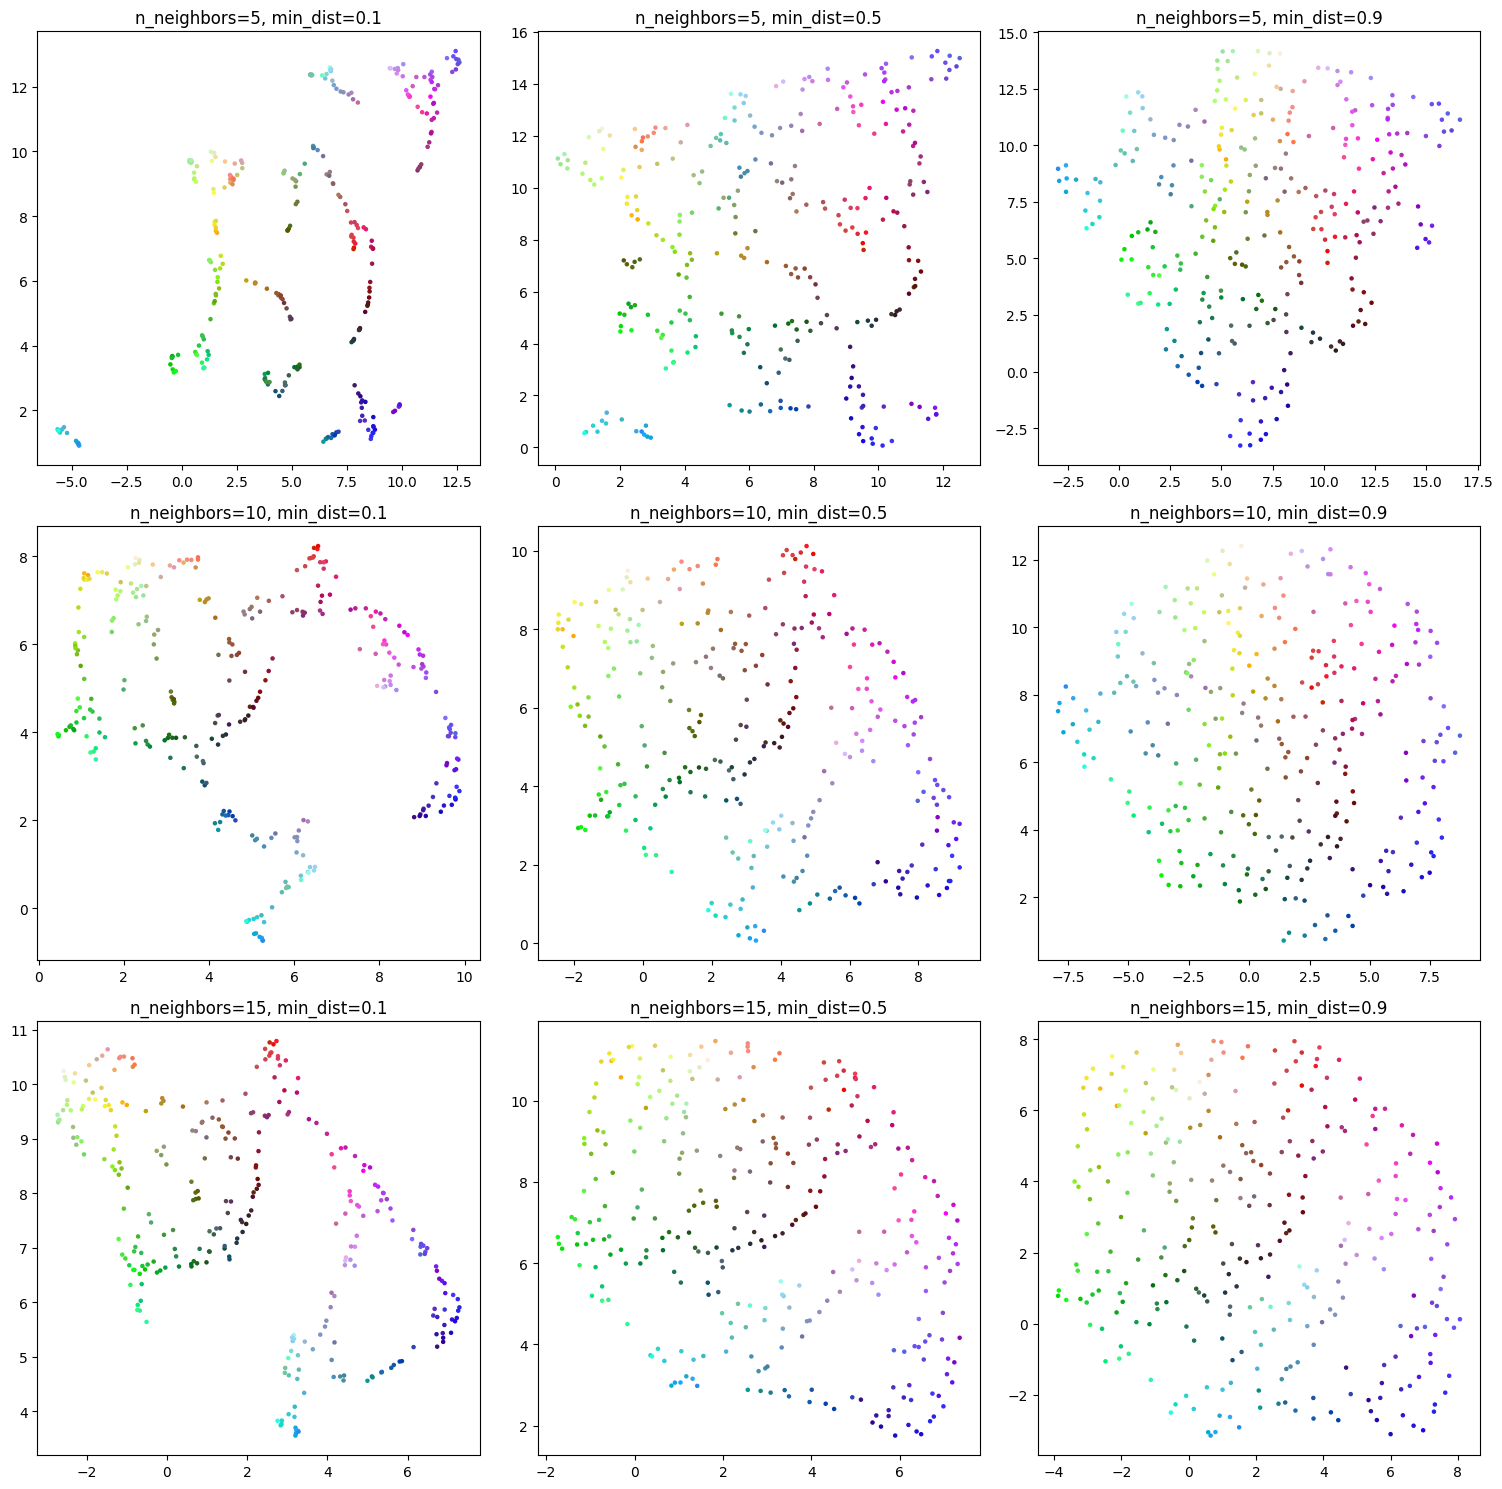

In [ ]:
import umap

# Grid of plots for different parameter values
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, n_neighbors in enumerate([5, 10, 15]):
    for j, min_dist in enumerate([0.1, 0.5, 0.9]):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(rgb_sample)
        axs[i, j].scatter(embedding[:, 0], embedding[:, 1], s=5, c=rgb_sample)
        axs[i, j].set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')

plt.tight_layout()
plt.show()


Topics will be determined from clusters in the data. Our points were evenly distributed in the 3D space, so clusters emerge from the relationships of the points alone.


A higher `n_neighbors` makes distant points have more influence on the position of any given point. A small `min_dist` forces points together, creating interesting but likely artificial patterns.


Larger `n_neighbors` and `min_dist` create the best representation of the entire cube. It's almost possible to see a projection.


Small `n_neighbors` and `min_dist` create the best representation of groups of colors and the relationships witin them.

If this was our data, the parameters would dictate if we get a single topic "color" or many topics ["blue", "green", "yellow"], etc.

What questions can be answered by preserving the local topics of the data?
What questions can be answered by preserving the global topics of the data?


# Clustering

We will create two artificial topics and to visualize clustering.

The data consists of two topics. Each topic is represented by a "donut" cloud. The donut clouds are intertwined, and so any projection techniques such as PCA would lose the ability to retain structural information.

Let's see how UMAP does.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go

# Function to create a donut
def create_torus(n_samples, R=20, r=1):
    u = np.random.uniform(0, 2*np.pi, n_samples)
    v = np.random.uniform(0, 2*np.pi, n_samples)
    x = (R + r*np.cos(v)) * np.cos(u)
    y = (R + r*np.cos(v)) * np.sin(u)
    z = r * np.sin(v)
    return np.vstack([x, y, z]).T

# Create two perpendicularly interlocked donuts
torus1 = create_torus(500)
torus2 = create_torus(500)
torus2[:, [0, 1, 2]] = torus2[:, [1, 2, 0]]  # rotate the second donut to make it perpendicular to the first
torus2[:, 0] += 10  # shift the second donut along the x-axis

n = 200
# Select a random sample of n points from each donuts
indices_torus1 = np.random.choice(torus1.shape[0], size=n, replace=False)
indices_torus2 = np.random.choice(torus2.shape[0], size=n, replace=False)
X_tori_sample = np.vstack([torus1[indices_torus1], torus2[indices_torus2]])

# Create a Plotly plot for the donut
fig = go.Figure(data=[go.Scatter3d(x=X_tori_sample[:n, 0], y=X_tori_sample[:n, 1], z=X_tori_sample[:n, 2], mode='markers', marker=dict(size=5, color='blue')),
                      go.Scatter3d(x=X_tori_sample[n:, 0], y=X_tori_sample[n:, 1], z=X_tori_sample[n:, 2], mode='markers', marker=dict(size=5, color='red'))])
fig.show()


Now the 2D representation using UMAP

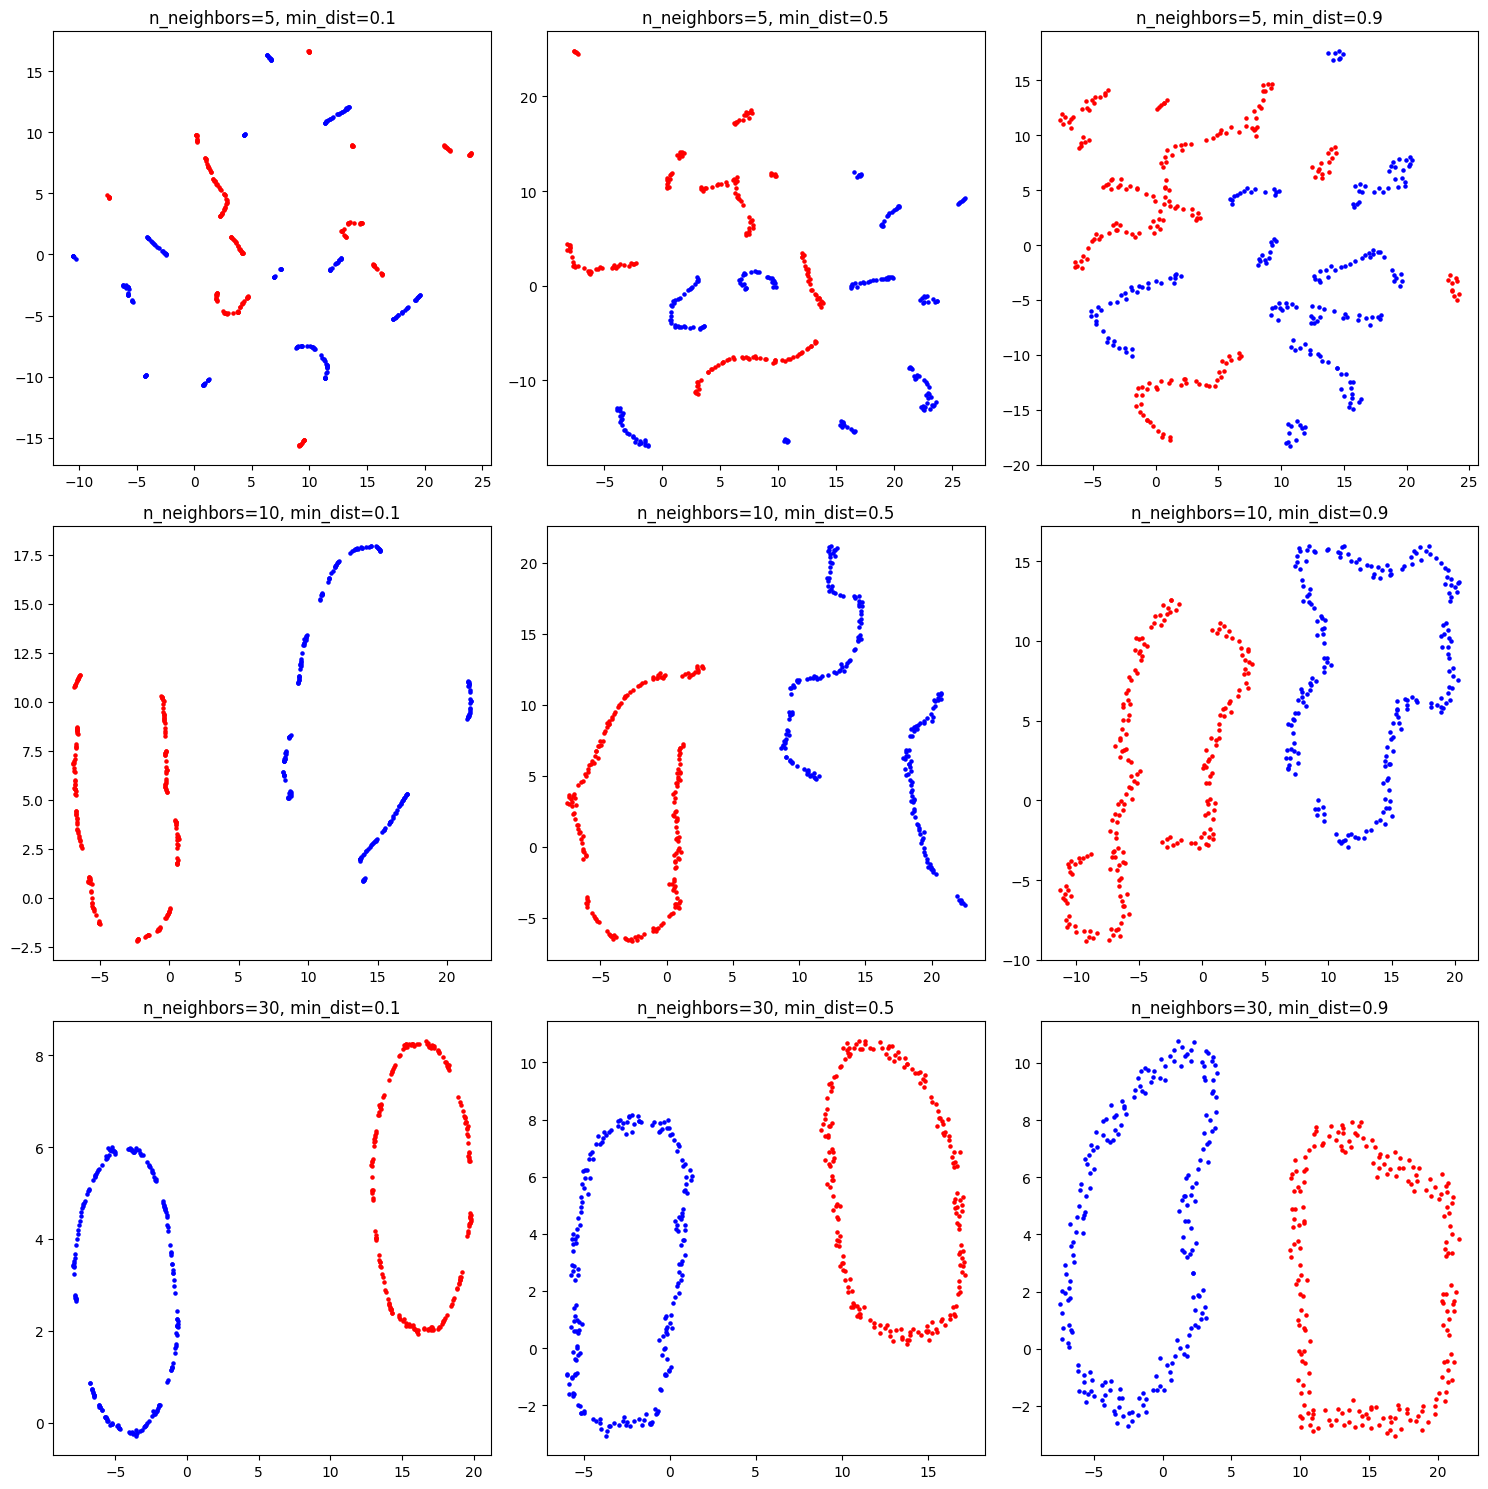

In [ ]:
# Grid of plots for different parameter values
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, n_neighbors in enumerate([5, 10, 30]):
    for j, min_dist in enumerate([0.1, 0.5, 0.9]):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(X_tori_sample)
        axs[i, j].scatter(embedding[:n, 0], embedding[:n, 1], s=5, color='blue')
        axs[i, j].scatter(embedding[n:, 0], embedding[n:, 1], s=5, color='red')
        axs[i, j].set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')

plt.tight_layout()
plt.show()


(see the effects of the `UMAP`'s `n_neighbors`, and `min_dist` parameters when representing the complex shape in 2D, and the differences between local and global features.)

Let's use a large `n_neighbors`, `min_dist` since, for this particular example, global structure is more important

`DBSCAN` also takes two hyperparameters:

1. `epsilon`: maximum distance for two points to be considered to be in the same neighborhood
 * A small `epsilon` makes it so points avoid clustering and prefer small groups, or even being alone.
 * A large `epsilon` leads to fewer, larger clusters, and might merge informative clusters together

2. `min_samples`: minimum number of elements to form a neighborhood
  * A small `min_samples` leads to many small clusters
  * A large `min_samples` can lead to more points being classified as "noise". This may result in a small number of large clusters with many outliers spread around them


Below are `DBSCAN`'s results with different parameters. Each color is a unique group created by `DBSCAN`

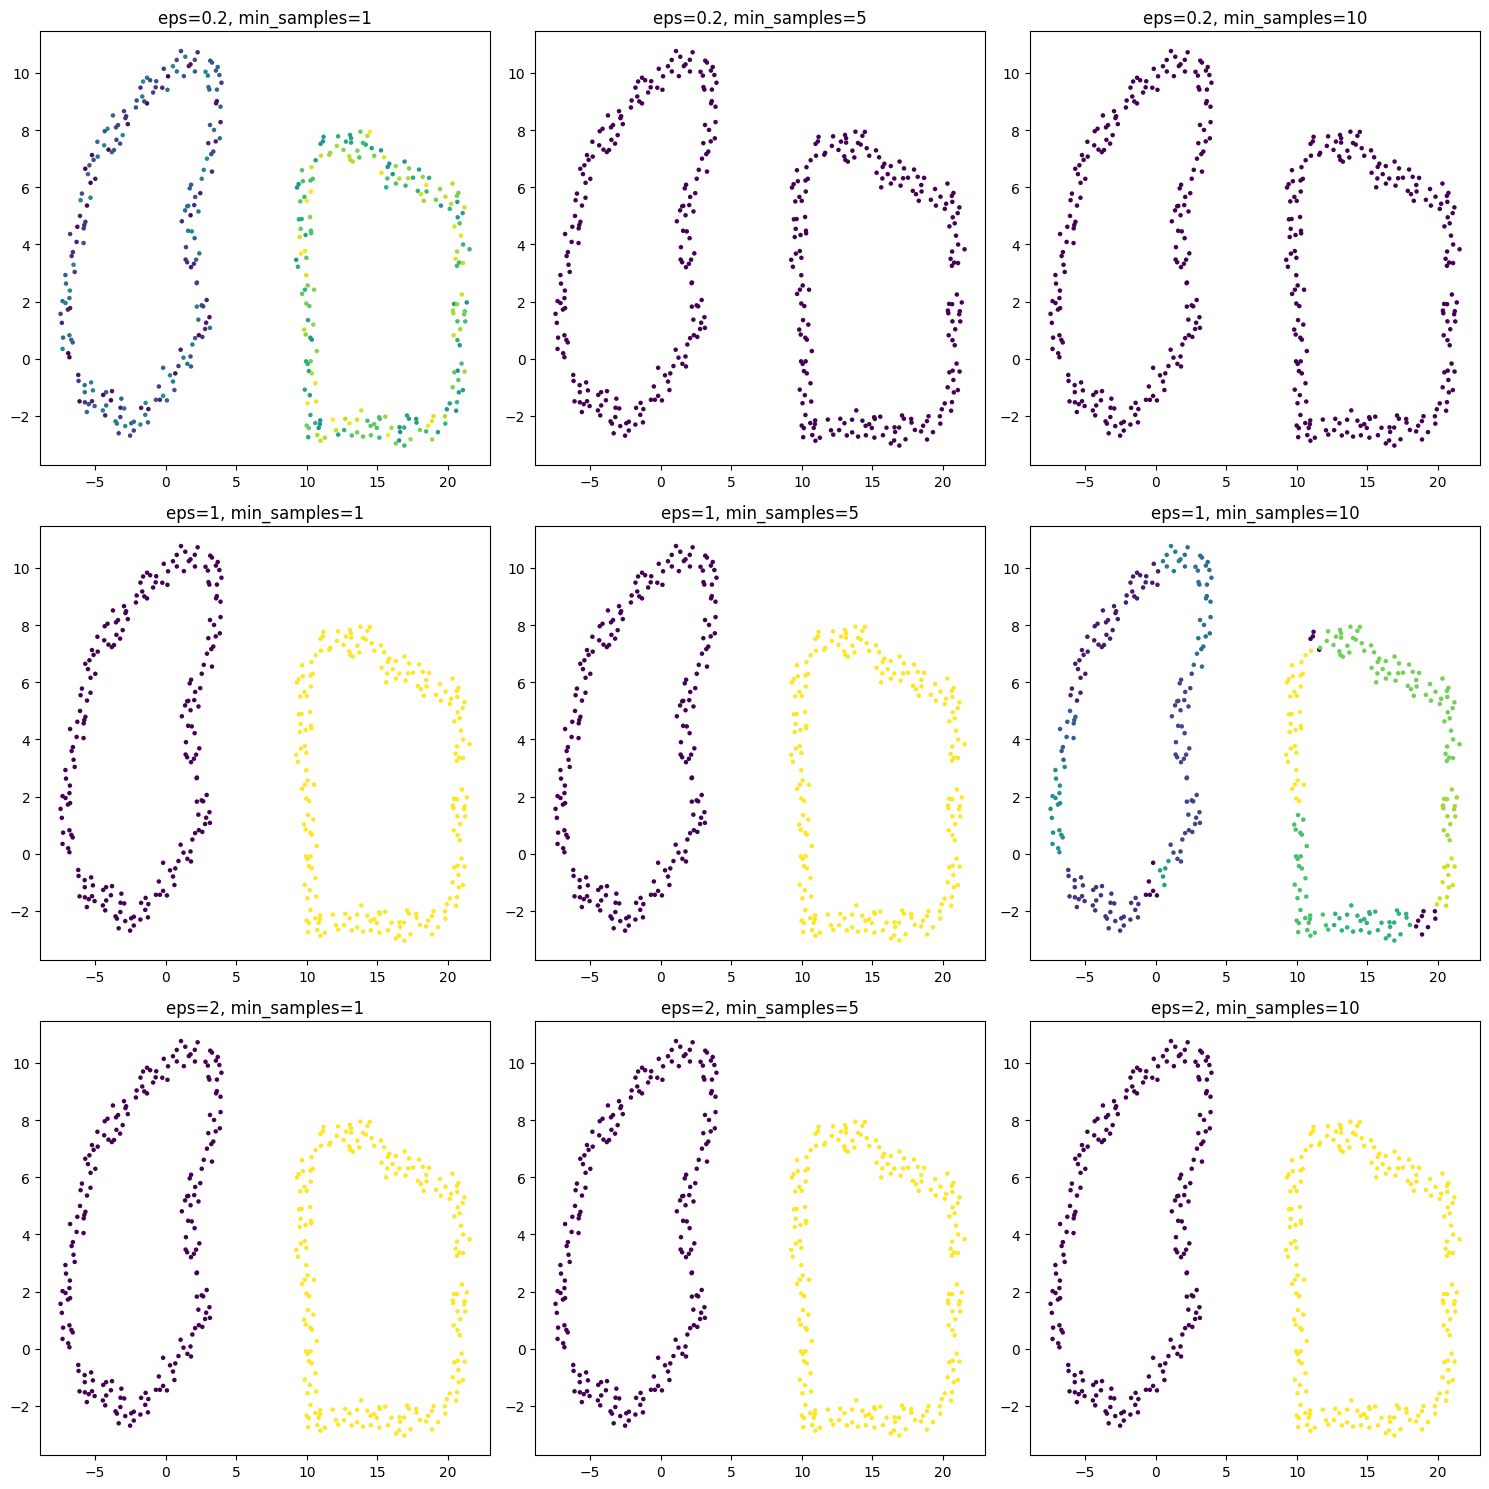

In [ ]:
n_neighbors = 30
min_dist = 0.9

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, eps in enumerate([0.2, 1, 2]):
    for j, min_samples in enumerate([1, 5, 10]):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(X_tori_sample)
        clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(embedding)
        axs[i, j].scatter(embedding[:, 0], embedding[:, 1], c=clustering.labels_, s=5)
        axs[i, j].set_title(f'eps={eps}, min_samples={min_samples}')

plt.tight_layout()
plt.show()

# Ignore everything that is drafted below

In [ ]:
import numpy as np

# Set the seed for reproducibility
np.random.seed(42)

# Number of entries and dimensions
n_entries = 1600
n_dimensions = 384

# Create the fake datab
fake_data = np.random.rand(n_entries, n_dimensions)


/usr/local/lib/python3.10/dist-packages/umap/spectral.py:260: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!



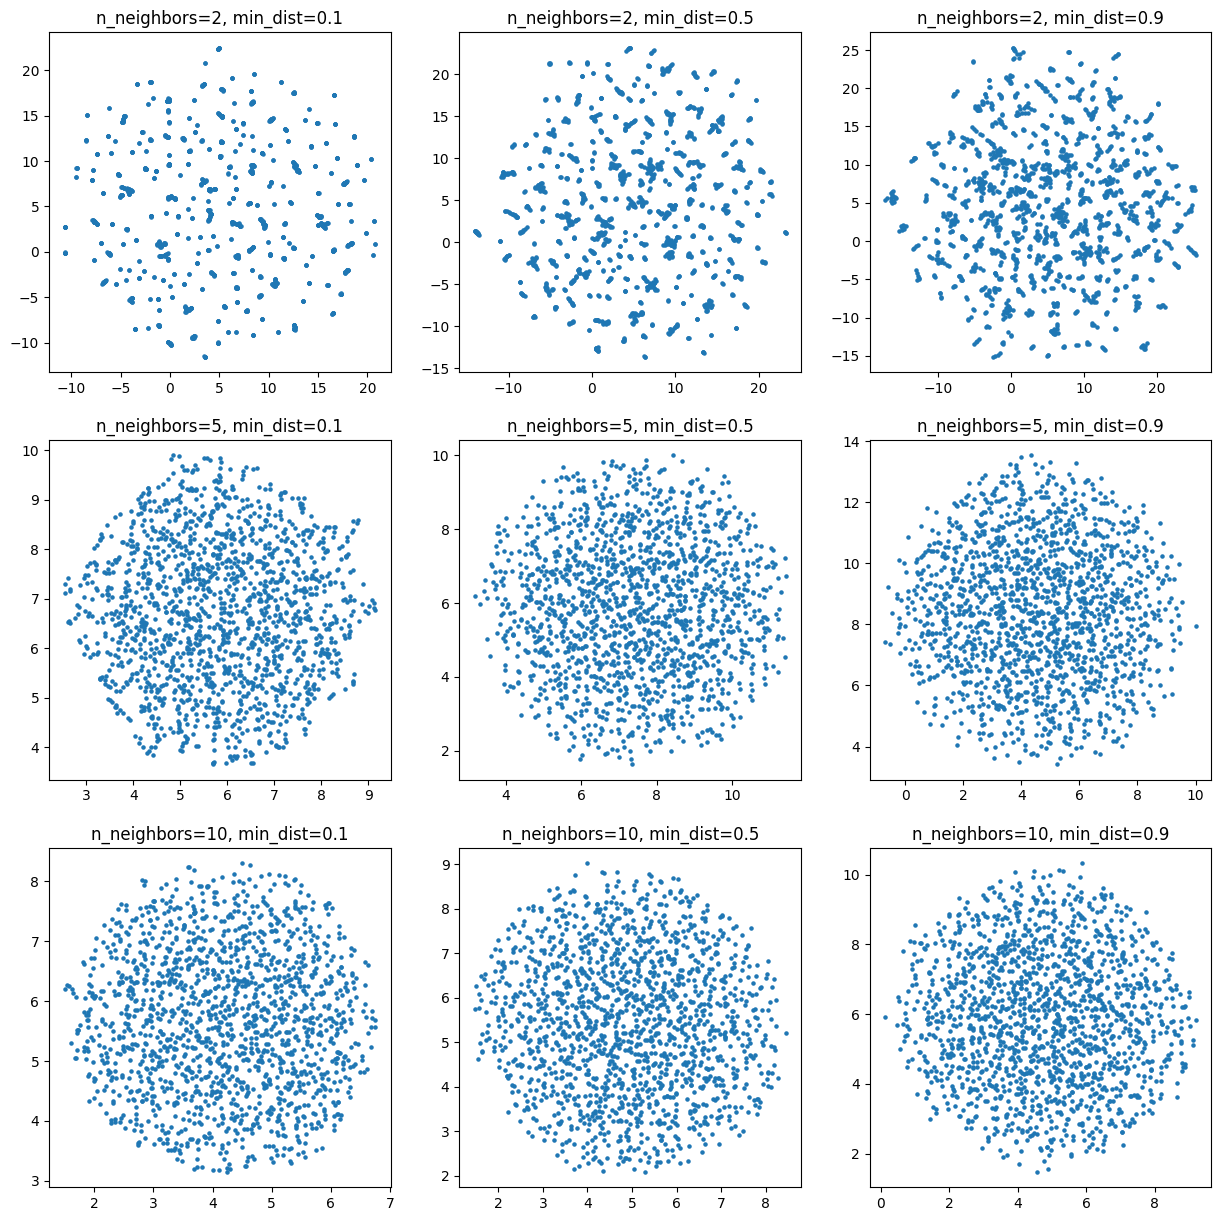

In [ ]:
# Grid of plots for different parameter values
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, n_neighbors in enumerate([2, 5, 10]):
    for j, min_dist in enumerate([0.1, 0.5, 0.9]):
        reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
        embedding = reducer.fit_transform(fake_data)
        axs[i, j].scatter(embedding[:, 0], embedding[:, 1], s=5)
        axs[i, j].set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import re
from docx import Document

raw_data = Document('/content/ObjectEllicitationNLP/Transcripts.docx')

def add_curly_braces(paragraph_text):
    """Add curly braces to three-digit numbers not surrounded by square brackets or curly braces."""
    numbers = re.findall(r'(?<![\[{])\b(\d{3})\b(?![\]}])', paragraph_text)
    for number in numbers:
        transformed_number = '{' + number + '}'
        paragraph_text = re.sub(r'\b' + number + r'\b', transformed_number, paragraph_text)
    return paragraph_text

def handle_square_brackets(paragraph_text):
    """Handle numbers inside square brackets with optional spaces and dashes."""
    matches = re.findall(r'\[([\d\s,-]+)\]', paragraph_text)
    for match in matches:
        numbers = []
        for num_range in re.split(r',\s*|\s+', match):
            num_range = num_range.strip()
            if '-' in num_range:
                start, end = num_range.split('-')
                numbers.extend(range(int(start), int(end) + 1))
            else:
                numbers.append(int(num_range))

        transformed = '[' + ']['.join(map(str, numbers)) + ']'
        paragraph_text = paragraph_text.replace('[' + match + ']', transformed)
    return paragraph_text

for each_paragraph in raw_data.paragraphs:
    each_paragraph.text = add_curly_braces(each_paragraph.text)
    each_paragraph.text = handle_square_brackets(each_paragraph.text)

def extract_info(paragraph_text):
    """Extract speaker, sentences, and objects from a paragraph text."""
    speaker_match = re.search(r'\{(\d{3})\}', paragraph_text)
    sentence_match = re.search(r': (.*)', paragraph_text)
    objects_match = re.findall(r'\[(\d{3})\]', paragraph_text)

    if speaker_match and sentence_match:
        speaker = speaker_match.group(1)
        sentence = sentence_match.group(1)
        objects = [int(object_id) for object_id in objects_match]
        return speaker, sentence, objects
    else:
        return None, None, None


def update_data(data, speaker, sentence, objects):
    """Update data dictionary with extracted speaker, sentence, and objects."""
    if speaker:
        if speaker in data:
            data[speaker]['statements'].append(sentence)
            data[speaker]['objects'].extend(objects)
        else:
            data[speaker] = {'subject': speaker, 'statements': [statement], 'objects': objects}

data = {}

for each_paragraph in raw_data.paragraphs:
    speaker, statement, objects = extract_info(each_paragraph.text)
    update_data(data, speaker, statement, objects)

del data['000']

import spacy
import numpy as np

w2v = spacy.load('en_core_web_md')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from bertopic import BERTopic

umap_model = UMAP(n_neighbors=8, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.05, metric='euclidean', cluster_selection_method='eom', prediction_data=True)


topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=5,
  verbose=True
)


In [ ]:
from gensim import models, corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
import numpy as np

def process_sentences(sentences):
    # Perform any pre-processing or additional processing for each sentence as needed
    processed_sentences = [simple_preprocess(sentence) for sentence in sentences]
    return processed_sentences

def train_topic_model(subject_data):
    # Extract sentence tokens and speaker information from the subject data
    sentence_tokens = subject_data['sentence_tokens']
    speakers = subject_data['speakers']

    # Process sentences and concatenate them with speaker information
    processed_sentences = process_sentences(sentence_tokens)
    sentences_with_speakers = [f"{speaker}: {' '.join(sentence)}" for speaker, sentence in zip(speakers, processed_sentences)]

    # Create a dictionary and corpus
    dictionary = corpora.Dictionary(processed_sentences)
    corpus = [dictionary.doc2bow(sentence) for sentence in processed_sentences]

    # Train an LDA topic model
    lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

    # Get the topics and their corresponding words
    topics = lda_model.print_topics(num_topics=5, num_words=10)

    # Get the topic distributions for each sentence
    topic_distributions = [lda_model.get_document_topics(doc) for doc in corpus]

    return topics, topic_distributions



for subject, subject_data in data.items():
    topics, topic_distributions = train_topic_model(subject_data)

    print(f"Subject: {subject}")
    print("Topics:")
    for topic in topics:
        print(topic)
    print("Topic Distributions:")
    for doc, topic_dist in zip(subject_data['sentence_tokens'], topic_distributions):
        print(f"Document: {doc}")
        print(f"Topic Distribution: {topic_dist}")
        print()


KeyError: ignored

In [ ]:
print(sentences_id)

['104 sounds good', '104 I didn’t even see that bag.', '104 this is set #1?', '104 this one [204] feels rougher but pretty uniform, it all kind of feels the same.', "104 It doesn't roll very well and it kind of thumps–do you want me to talk louder?", "104 um and it kind of thumps when you throw it, it doesn't bounce or anything.", '104 then this one [201] is pokey, spiky, ooh and it lights up when you bounce it.', "104 it also doesn't bounce that much but still it feels really artificial like kind of slimy almost.", "104 um like I definitely wouldn't put that in my mouth.", "104 this one [203] has little suction cups all the way around which--oh I like the sound it makes--little pop--and it does roll well but it's not satisfying at all, yeah.", '104 this one [202] is my favorite.', "104 it's it's smooth and soft and it bounces well and it's heavy, like it's solid, and it's a little squishy if I like put some effort into it and yeah.", '104 so this one I think rolls well.', '104 then th

The data is now organized in a dictionary.

In [ ]:
from bertopic import BERTopic

# Instantiate a BERTopic model with RoBERTa
topic_model = BERTopic(embedding_model="roberta-base-nli-mean-tokens")

# Fit and transform our sentences to get topics
topics, _ = topic_model.fit_transform(sentences)



In [ ]:
bert diffrences to w2v: word order, two words with different contexts (banj of hte river)